# Porfolio Project 1
## customer shopping analysis project using public data

### Import given data

In [1]:
import pandas as pd
import os
data_path = os.path.join('data', 'shopping_trends.csv')
df = pd.read_csv(data_path)
df.head()
print(df.columns)
print(df.isnull().sum())

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases'],
      dtype='object')
Customer ID                 0
Age                         0
Gender                      0
Item Purchased              0
Category                    0
Purchase Amount (USD)       0
Location                    0
Size                        0
Color                       0
Season                      0
Review Rating               0
Subscription Status         0
Payment Method              0
Shipping Type               0
Discount Applied            0
Promo Code Used             0
Previous Purchases          0
Preferred Payment Method    0
Frequency of Purchases      0
dtype: int64


### Quick data cleaning

In [2]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.to_csv(os.path.join('data', 'shopping_trends_cleaned.csv'), index=False)

sanity check

In [3]:
# Display basic information about the DataFrame
print("\nDataFrame Info:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Display unique values and their counts for categorical columns
print("\nUnique Values in Categorical Columns:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}:")
    print(df[col].value_counts())



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               3900 non-null   int64  
 1   age                       3900 non-null   int64  
 2   gender                    3900 non-null   object 
 3   item_purchased            3900 non-null   object 
 4   category                  3900 non-null   object 
 5   purchase_amount_(usd)     3900 non-null   int64  
 6   location                  3900 non-null   object 
 7   size                      3900 non-null   object 
 8   color                     3900 non-null   object 
 9   season                    3900 non-null   object 
 10  review_rating             3900 non-null   float64
 11  subscription_status       3900 non-null   object 
 12  payment_method            3900 non-null   object 
 13  shipping_type             3900 non-null   obje

### Load into SQLite

In [4]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('shopping.db')
df = pd.read_csv(os.path.join('data', 'shopping_trends_cleaned.csv'))
df.to_sql('shopping', conn, if_exists='replace', index=False)

3900

In [7]:
query = '''
SELECT category, SUM("purchase_amount_(usd)") as total_sales
FROM shopping
GROUP BY category
ORDER BY total_sales DESC
LIMIT 5
'''
top_categories = pd.read_sql(query, conn)
top_categories.to_csv(os.path.join('data', 'top_categories.csv'), index=False)

### RFM-like analysis

In [9]:
rfm = df.groupby('customer_id').agg({
    'frequency_of_purchases': 'first',
    'purchase_amount_(usd)': 'sum',
    'previous_purchases': 'sum'
}).rename(columns={
    'frequency_of_purchases': 'frequency',
    'purchase_amount_(usd)': 'monetary',
    'previous_purchases': 'recency'
})
rfm.to_csv(os.path.join('data', 'rfm_analysis.csv'), index=False)

Clustering

In [11]:
from sklearn.cluster import KMeans
import numpy as np

# Convert frequency to numeric values
frequency_map = {
    'Weekly': 52,
    'Fortnightly': 26, 
    'Monthly': 12,
    'Quarterly': 4,
    'Bi-Weekly': 26,
    'Annually': 1,
    'Every 3 Months': 4
}
rfm['frequency'] = rfm['frequency'].map(frequency_map)

# Scale the numeric features
rfm_scaled = (rfm - rfm.mean()) / rfm.std()

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.to_csv(os.path.join('data', 'rfm_segments.csv'), index=False)

Visualize

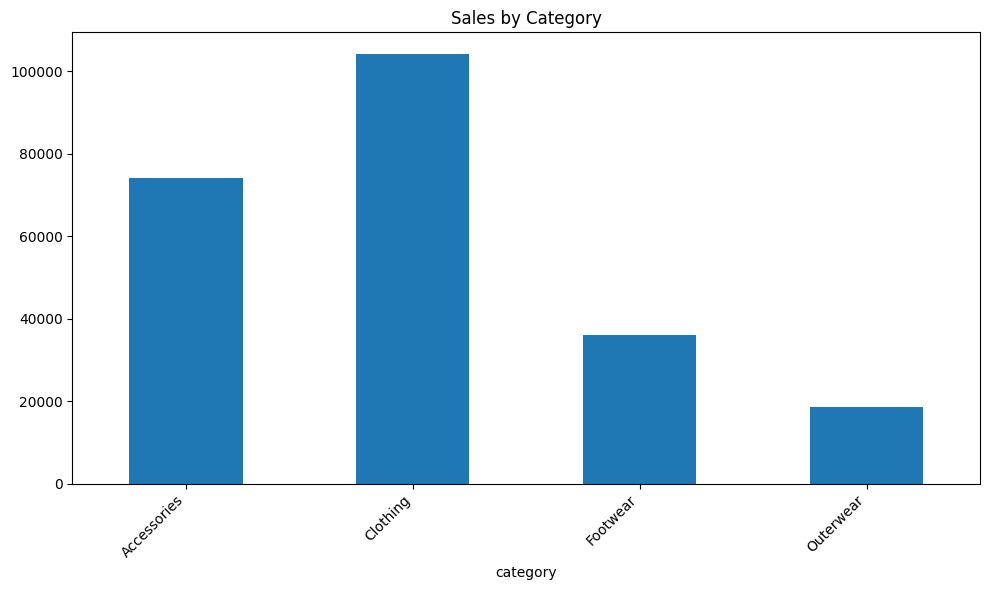

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

category_sales = df.groupby('category')['purchase_amount_(usd)'].sum()

plt.figure(figsize=(10, 6))
ax = category_sales.plot(kind='bar', title='Sales by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and display
plt.savefig(os.path.join('images', 'category_sales.png'))
plt.show()
plt.close()